In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Shanghai = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ShanghaiPM20100101_20151231.csv")


In [3]:
#Delet non-useful data
##Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
##               axis=1,
##              inplace=True)

In [4]:
Shanghai.dropna(axis=0, how="any",inplace=True)

In [5]:
# from datetime import datetime
Shanghai['Time'] = pd.to_datetime(Shanghai['year'].map(str) +"/"+ Shanghai['month'].map(str) +"/"+ Shanghai['day'].map(str)+" "+Shanghai['hour'].map(str)+":00:00")
#Beijing

In [7]:
Shanghai.groupby(['year']).size()

year
2013    7276
2014    7311
2015    6849
dtype: int64

In [8]:
by_hour = Shanghai.groupby(['Time']).mean()
by_hour.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
Time,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,26305,2013,1,1,0,4,66.0,70.0,71.0,-5.0,69.00,1023.0,0.0,60.0,0.0,0.0
2013-01-01 01:00:00,26306,2013,1,1,1,4,67.0,76.0,72.0,-5.0,69.00,1023.0,0.0,62.0,0.0,0.0
2013-01-01 03:00:00,26308,2013,1,1,3,4,73.0,78.0,74.0,-4.0,74.41,1023.0,0.0,65.0,0.0,0.0
2013-01-01 04:00:00,26309,2013,1,1,4,4,75.0,77.0,77.0,-4.0,80.04,1023.0,-1.0,68.0,0.0,0.0
2013-01-01 05:00:00,26310,2013,1,1,5,4,73.0,78.0,80.0,-4.0,80.04,1023.0,-1.0,70.0,0.0,0.0


In [9]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2015-12-31 13:00:00', '2015-12-31 14:00:00',
               '2015-12-31 15:00:00', '2015-12-31 16:00:00',
               '2015-12-31 17:00:00', '2015-12-31 18:00:00',
               '2015-12-31 19:00:00', '2015-12-31 20:00:00',
               '2015-12-31 21:00:00', '2015-12-31 22:00:00'],
              dtype='datetime64[ns]', name='Time', length=26279, freq='H')


In [10]:
by_hour['Time'] = by_hour.index
by_hour['Time']

Time
2013-01-01 00:00:00   2013-01-01 00:00:00
2013-01-01 01:00:00   2013-01-01 01:00:00
2013-01-01 02:00:00   2013-01-01 02:00:00
2013-01-01 03:00:00   2013-01-01 03:00:00
2013-01-01 04:00:00   2013-01-01 04:00:00
                              ...        
2015-12-31 18:00:00   2015-12-31 18:00:00
2015-12-31 19:00:00   2015-12-31 19:00:00
2015-12-31 20:00:00   2015-12-31 20:00:00
2015-12-31 21:00:00   2015-12-31 21:00:00
2015-12-31 22:00:00   2015-12-31 22:00:00
Freq: H, Name: Time, Length: 26279, dtype: datetime64[ns]

In [11]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20150101030000'))]

In [13]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
#data_13

In [14]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20130112030000'))]
data = data.set_index(data.index).asfreq('H')
#data

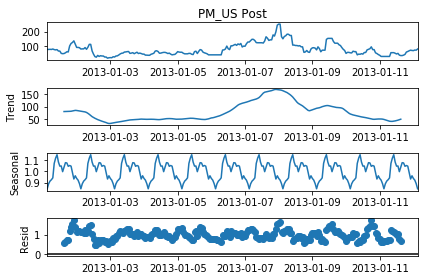

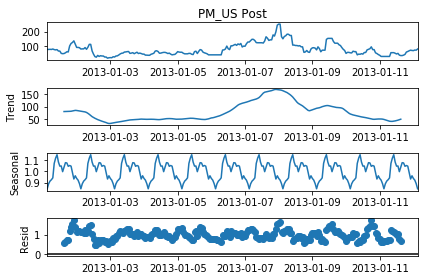

In [15]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [16]:
len(data_13)

731

In [17]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

In [18]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(data_13['PM_US Post'], start_p = 0, start_q = 0, 
                          max_p = 4, max_q = 4, m=7,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 7) (constant=True); AIC=7489.585, BIC=7503.340, Time=0.274 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=True); AIC=7847.394, BIC=7856.564, Time=0.026 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=7542.276, BIC=7560.615, Time=0.331 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 7) (constant=True); AIC=7390.596, BIC=7408.935, Time=0.718 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=False); AIC=7845.399, BIC=7849.984, Time=0.018 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 0, 7) (constant=True); AIC=7768.208, BIC=7781.962, Time=0.082 seconds
Fit ARIMA: (0, 0, 1)x(1, 1, 1, 7) (constant=True); AIC=7392.433, BIC=7415.357, Time=1.346 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 2, 7) (constant=True); AIC=7392.440, BIC=7415.364, Time=2.477 seconds
Fit ARIMA: (0, 0, 1)x(1, 1, 0, 7) (constant=True); AIC=7552.946, BIC=7571.285, Time=0.360 seconds
Fit ARIMA: (0, 0, 1)x(1, 1, 2, 7) (constant=True); AIC=7391.849, BIC=7419.

In [19]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  731
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 7)   Log Likelihood               -3651.366
Date:                             Fri, 10 Apr 2020   AIC                           7316.732
Time:                                     18:31:40   BIC                           7348.825
Sample:                                          0   HQIC                          7329.118
                                             - 731                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0019      0.005     -0.387      0.699      -0.011       0.008
ar.L1          0.9882      0.010     98.874      0.000       0.969       1.008
ma.L1         -0.6203      0.028    -21.893      0.000      -0.676      -0.565
ma.L2         -0.1839      0.035     -5.214      0.000      -0.253      -0.115
ma.L3         -0.0849      0.031     -2.746      0.006      -0.145      -0.024
ma.S.L7       -0.9972      0.075    -13.334      0.000      -1.144      -0.851
sigma2      1353.0961    103.387     13.088      0.000    1150.462    1555.731
===================================================================================
Ljung-Box (Q):                       45.99   Jarque-Bera (JB):               800.41
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             1.32
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Fit a SARIMAX(1, 0, 3)x(0, 1, 1, 7)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (1, 0, 3),  
                seasonal_order =(0, 1, 1, 7))

In [28]:
result = model.fit() 

In [29]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          PM_US Post   No. Observations:                  575
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 7)   Log Likelihood               -2882.364
Date:                             Fri, 10 Apr 2020   AIC                           5776.728
Time:                                     18:34:04   BIC                           5802.781
Sample:                                 01-01-2013   HQIC                          5786.895
                                      - 07-29-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9877      0.012     83.907      0.000       0.965       1.011
ma.L1         -0.5684      0.032    -17.532      0.000      -0.632      -0.505
ma.L2         -0.2261      0.038     -5.908      0.000      -0.301      -0.151
ma.L3         -0.0878      0.034     -2.580      0.010      -0.154      -0.021
ma.S.L7       -0.9985      0.225     -4.445      0.000      -1.439      -0.558
sigma2      1425.6103    311.801      4.572      0.000     814.491    2036.730
===================================================================================
Ljung-Box (Q):                       55.51   Jarque-Bera (JB):               585.10
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

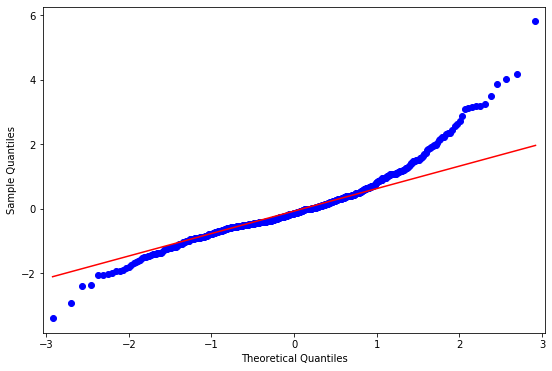

In [30]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

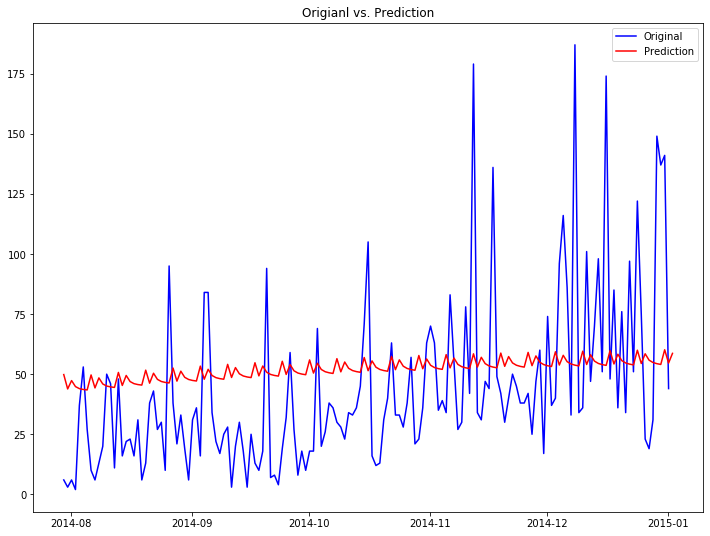

In [31]:
predict_ARMA = result.predict(start =575, end = 731) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 